Runtime Environment

In [8]:
!pip install liac-arff
!pip install xgboost

In [9]:
!pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-8nwnf5xo
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-8nwnf5xo
  Resolved https://github.com/KindXiaoming/pykan.git to commit ecde4ec3274d3bef1ad737479cf126aed38ab530
  Preparing metadata (setup.py) ... done


In [10]:
import arff
print(arff.__file__)

/usr/local/lib/python3.11/dist-packages/arff.py


In [11]:
import pandas as pd
from scipy.io import arff
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import time
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from kan import KAN

Loading Dataset

In [12]:
# Load the ARFF file
file_path = "/content/TimeBasedFeatures-Dataset-15s-AllinOne.arff"
data, meta = arff.loadarff(file_path)

# Convert to DataFrame
df = pd.DataFrame(data)

# Decode the label column ('class1') from bytes to string
df['class1'] = df['class1'].str.decode('utf-8')

# Preview
print(df.head())
print(df['class1'].value_counts())

     duration  total_fiat  total_biat   min_fiat   min_biat       max_fiat  \
0   9368711.0        16.0         4.0  1564818.0  1549373.0  190205.285714   
1   7340238.0        18.0         4.0  1567554.0  1527893.0  165686.977273   
2   4644225.0        29.0        15.0  1270547.0  1079974.0  165865.178571   
3   4978735.0        19.0         8.0  2492050.0  2457286.0  239543.250000   
4  11838189.0        19.0        10.0  3094089.0  3093543.0  243766.500000   

        max_biat      mean_fiat      mean_biat  flowPktsPerSecond  ...  \
0  203290.456522  389822.391917  370323.719754          10.353612  ...   
1  186914.846154  317267.548742  304370.651301          11.580006  ...   
2  195302.130435  329473.126261  300492.588227          11.412022  ...   
3  276596.388889  612435.304238  628339.573544           8.034169  ...   
4  295954.725000  599721.781709  625632.703972           7.602514  ...   

     std_flowiat  min_active   mean_active  max_active    std_active  \
0  267600.1984

In [13]:
df.to_csv("/content/TimeBasedFeatures_dataset_15s_allinone.csv", index=False)
print("✅ Saved to CSV!")

✅ Saved to CSV!


## Data Exploration

In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18758 entries, 0 to 18757
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   duration            18758 non-null  float64
 1   total_fiat          18758 non-null  float64
 2   total_biat          18758 non-null  float64
 3   min_fiat            18758 non-null  float64
 4   min_biat            18758 non-null  float64
 5   max_fiat            18758 non-null  float64
 6   max_biat            18758 non-null  float64
 7   mean_fiat           18758 non-null  float64
 8   mean_biat           18758 non-null  float64
 9   flowPktsPerSecond   18758 non-null  float64
 10  flowBytesPerSecond  18758 non-null  float64
 11  min_flowiat         18758 non-null  float64
 12  max_flowiat         18758 non-null  float64
 13  mean_flowiat        18758 non-null  float64
 14  std_flowiat         18758 non-null  float64
 15  min_active          18758 non-null  float64
 16  mean

<ipython-input-15-a73f4726e3b7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='class1', order=df['class1'].value_counts().index, palette='Set2')


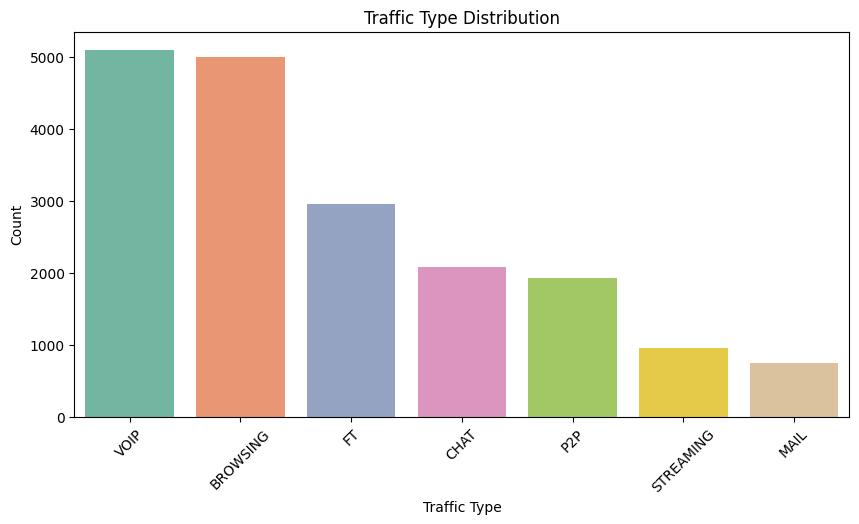

In [15]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='class1', order=df['class1'].value_counts().index, palette='Set2')
plt.title("Traffic Type Distribution")
plt.xlabel("Traffic Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

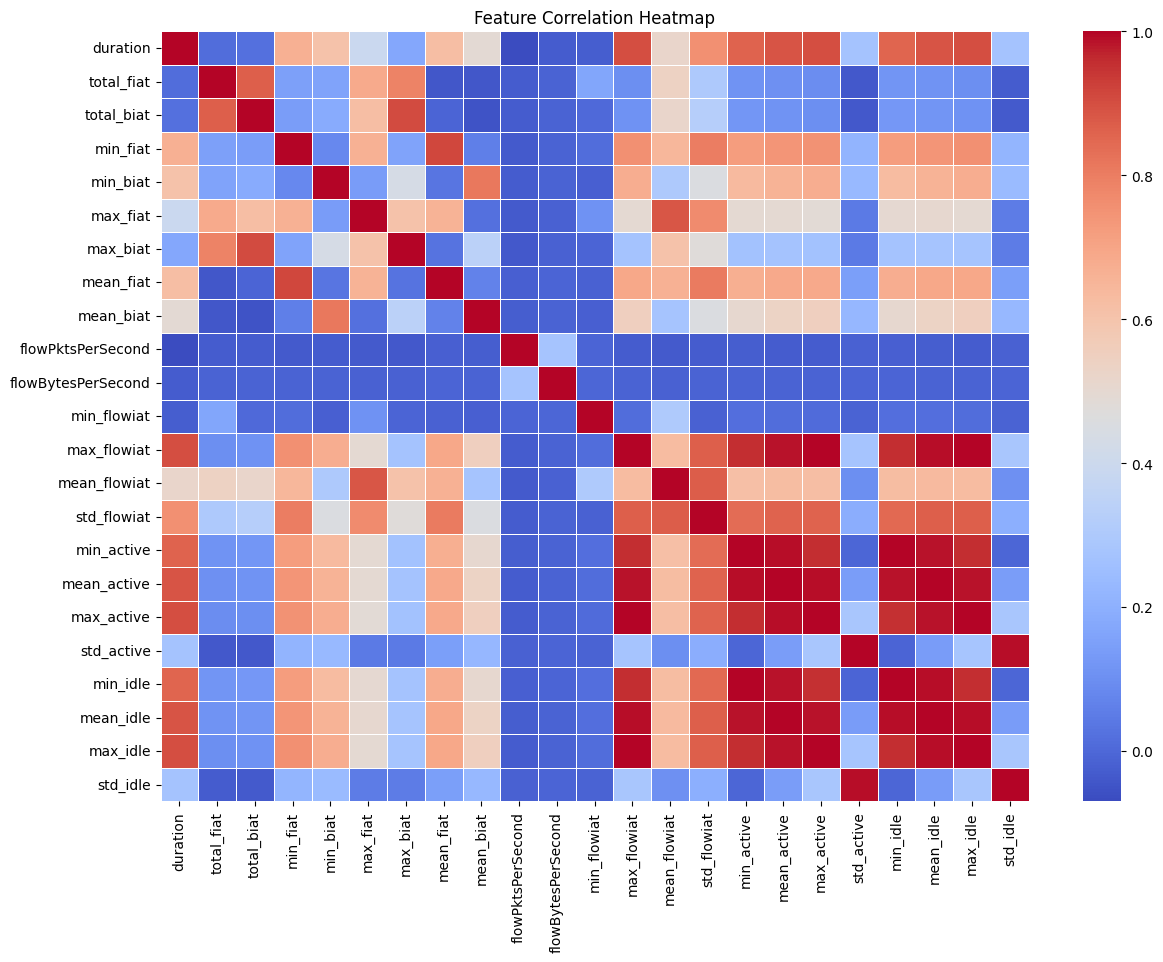

In [16]:
plt.figure(figsize=(14, 10))
corr = df.drop(['class1'], axis=1).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [17]:
corr_matrix = df.drop('class1', axis=1).corr()
high_corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1.0]
print("🔥 Top correlated pairs:\n", high_corr_pairs.drop_duplicates().head(10))

🔥 Top correlated pairs:
 max_flowiat  max_idle       0.999846
min_idle     min_active     0.997263
mean_idle    mean_active    0.997094
max_idle     max_active     0.996398
max_active   max_flowiat    0.996024
mean_idle    min_idle       0.989233
std_active   std_idle       0.989051
min_active   mean_active    0.989021
mean_idle    max_flowiat    0.988891
max_idle     mean_idle      0.988876
dtype: float64


In [18]:
variances = df.var(numeric_only=True).sort_values()
print("🔍 Low variance features:\n", variances.head(5))

🔍 Low variance features:
 flowPktsPerSecond    3.654105e+08
min_flowiat          1.965286e+11
mean_flowiat         1.972417e+12
total_fiat           5.031925e+12
total_biat           5.412332e+12
dtype: float64


In [19]:
skewed = df.drop(columns=['class1']).skew().sort_values(ascending=False)
print("📈 Most skewed features:\n", skewed.head(5))

📈 Most skewed features:
 flowBytesPerSecond    57.518702
std_idle              34.377980
std_active            33.346030
min_biat              32.902625
flowPktsPerSecond     27.779703
dtype: float64


## Data Preprocessing

In [20]:
print("🧽 Missing values:\n", df.isnull().sum())
print("\n🧱 Constant columns:\n", df.loc[:, df.nunique() <= 1].columns.tolist())
print("\n🔁 Duplicate rows:", df.duplicated().sum())

🧽 Missing values:
 duration              0
total_fiat            0
total_biat            0
min_fiat              0
min_biat              0
max_fiat              0
max_biat              0
mean_fiat             0
mean_biat             0
flowPktsPerSecond     0
flowBytesPerSecond    0
min_flowiat           0
max_flowiat           0
mean_flowiat          0
std_flowiat           0
min_active            0
mean_active           0
max_active            0
std_active            0
min_idle              0
mean_idle             0
max_idle              0
std_idle              0
class1                0
dtype: int64

🧱 Constant columns:
 []

🔁 Duplicate rows: 706


In [21]:
df_cleaned = df.drop_duplicates()
print(f"✅ Cleaned DataFrame shape: {df_cleaned.shape}")

✅ Cleaned DataFrame shape: (18052, 24)


In [22]:
features_to_drop = [
    'max_idle',      # Drop one from max_flowiat vs max_idle
    'min_idle',      # Drop one from min_idle vs min_active
    'mean_idle',     # Drop one from mean_idle vs mean_active
    'std_idle',      # Drop one from std_idle vs std_active
]

df_cleaned = df_cleaned.drop(columns=features_to_drop)
print(f"🧹 Dropped {len(features_to_drop)} highly correlated features.")
print(f"📊 New shape: {df_cleaned.shape}")

🧹 Dropped 4 highly correlated features.
📊 New shape: (18052, 20)


Label Encoding

In [23]:
# Encode class1 to numeric labels
label_encoder = LabelEncoder()
df_cleaned['label'] = label_encoder.fit_transform(df_cleaned['class1'])

# Optional: view mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("📚 Label mapping:", label_mapping)

# Drop original class column
df_cleaned = df_cleaned.drop(columns=['class1'])

📚 Label mapping: {'BROWSING': np.int64(0), 'CHAT': np.int64(1), 'FT': np.int64(2), 'MAIL': np.int64(3), 'P2P': np.int64(4), 'STREAMING': np.int64(5), 'VOIP': np.int64(6)}


In [24]:
X = df_cleaned.drop(columns=['label'])
y = df_cleaned['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"🧪 Training shape: {X_train.shape}")
print(f"🧾 Testing shape: {X_test.shape}")

🧪 Training shape: (14441, 19)
🧾 Testing shape: (3611, 19)


## Model Implementation

In [25]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "SVM": SVC()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n🚀 Training: {name}")
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)

    print(f"🕒 Training Time: {end - start:.2f} sec")
    print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))



🚀 Training: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

🕒 Training Time: 27.74 sec
✅ Accuracy: 0.6189
              precision    recall  f1-score   support

           0       0.72      0.64      0.68      1000
           1       0.39      0.18      0.24       409
           2       0.37      0.48      0.42       547
           3       0.00      0.00      0.00       132
           4       0.30      0.49      0.37       321
           5       0.44      0.52      0.48       185
           6       0.92      0.98      0.95      1017

    accuracy                           0.62      3611
   macro avg       0.45      0.47      0.45      3611
weighted avg       0.61      0.62      0.61      3611


🚀 Training: Random Forest
🕒 Training Time: 6.22 sec
✅ Accuracy: 0.9106
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1000
           1       0.79      0.80      0.80       409
           2       0.86      0.85      0.85       547
           3       0.82      0.78      0.80       132
           4  

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:37:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🕒 Training Time: 3.17 sec
✅ Accuracy: 0.9280
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1000
           1       0.85      0.83      0.84       409
           2       0.87      0.88      0.87       547
           3       0.85      0.83      0.84       132
           4       0.96      0.95      0.95       321
           5       0.94      0.88      0.91       185
           6       1.00      0.99      1.00      1017

    accuracy                           0.93      3611
   macro avg       0.91      0.90      0.91      3611
weighted avg       0.93      0.93      0.93      3611


🚀 Training: SVM
🕒 Training Time: 6.81 sec
✅ Accuracy: 0.5868
              precision    recall  f1-score   support

           0       0.45      0.94      0.61      1000
           1       0.47      0.12      0.19       409
           2       0.54      0.22      0.31       547
           3       0.00      0.00      0.00       132
           4       0.26  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
# 🧠 Evaluate and compare models on training and testing sets
comparison = []

for name, model in models.items():
    print(f"\n🔍 Evaluating: {name}")
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    comparison.append({
        "Model": name,
        "Training Accuracy": round(train_acc, 4),
        "Testing Accuracy": round(test_acc, 4),
        "Overfitting Gap": round(train_acc - test_acc, 4)
    })

# Create and display the comparison DataFrame
comparison_df = pd.DataFrame(comparison)
print("\n📊 Model Accuracy Comparison:")
print(comparison_df.sort_values(by="Testing Accuracy", ascending=False))



🔍 Evaluating: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🔍 Evaluating: Random Forest

🔍 Evaluating: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:38:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 Evaluating: SVM

📊 Model Accuracy Comparison:
                 Model  Training Accuracy  Testing Accuracy  Overfitting Gap
2              XGBoost             0.9922            0.9280           0.0642
1        Random Forest             0.9981            0.9106           0.0875
0  Logistic Regression             0.6183            0.6189          -0.0006
3                  SVM             0.5880            0.5868           0.0012


KAN model

In [27]:
# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float32

# Convert your real dataset into KAN's format
dataset = {
    'train_input': torch.tensor(X_train.values, dtype=dtype).to(device),
    'test_input': torch.tensor(X_test.values, dtype=dtype).to(device),
    'train_label': torch.tensor(y_train.values, dtype=torch.long).to(device),
    'test_label': torch.tensor(y_test.values, dtype=torch.long).to(device),
}

print("✅ Dataset prepared for KAN!")
print("📊 Train Input Shape:", dataset['train_input'].shape)
print("📊 Train Label Shape:", dataset['train_label'].shape)


✅ Dataset prepared for KAN!
📊 Train Input Shape: torch.Size([14441, 19])
📊 Train Label Shape: torch.Size([14441])


In [28]:
# Step 1: Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Convert to torch tensors for KAN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float32

dataset = {
    'train_input': torch.tensor(X_train_scaled, dtype=dtype).to(device),
    'test_input': torch.tensor(X_test_scaled, dtype=dtype).to(device),
    'train_label': torch.tensor(y_train.values, dtype=torch.long).to(device),
    'test_label': torch.tensor(y_test.values, dtype=torch.long).to(device),
}

print("✅ Normalization complete & tensors prepared!")
print("📊 Scaled Train Input Shape:", dataset['train_input'].shape)
print("📊 Train Label Shape:", dataset['train_label'].shape)

✅ Normalization complete & tensors prepared!
📊 Scaled Train Input Shape: torch.Size([14441, 19])
📊 Train Label Shape: torch.Size([14441])


In [30]:
# Define model
input_dim = dataset['train_input'].shape[1]  # 19 features
output_classes = len(torch.unique(dataset['train_label']))
model = KAN(width=[input_dim, 32, output_classes], grid=5, k=3, seed=42, device=device)

# Accuracy functions
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

# Train model
from torch.nn import CrossEntropyLoss
results = model.fit(
    dataset,
    opt="LBFGS",
    steps=900,  # results
    metrics=(train_acc, test_acc),
    loss_fn=CrossEntropyLoss()
)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.29e-01 | test_loss: 9.41e-01 | reg: 1.20e+03 | : 100%|█| 900/900 [10:35<00:00,  1.42

saving model version 0.1


In [31]:
print("🚀 Final Train Accuracy:", train_acc().item())
print("🧪 Final Test Accuracy:", test_acc().item())

🚀 Final Train Accuracy: 0.9006993770599365
🧪 Final Test Accuracy: 0.8421489596366882


In [32]:
# KAN results
kan_train_accuracy = round(train_acc().item(), 4)
kan_test_accuracy = round(test_acc().item(), 4)
kan_gap = round(kan_train_accuracy - kan_test_accuracy, 4)

# Create KAN result as DataFrame
kan_result = pd.DataFrame([{
    "Model": "KAN",
    "Training Accuracy": kan_train_accuracy,
    "Testing Accuracy": kan_test_accuracy,
    "Overfitting Gap": kan_gap
}])

# Concatenate to existing comparison_df
comparison_df = pd.concat([comparison_df, kan_result], ignore_index=True)

# Display updated comparison
print("\n📊 Updated Model Accuracy Comparison (including KAN):")
print(comparison_df.sort_values(by="Testing Accuracy", ascending=False))


📊 Updated Model Accuracy Comparison (including KAN):
                 Model  Training Accuracy  Testing Accuracy  Overfitting Gap
2              XGBoost             0.9922            0.9280           0.0642
1        Random Forest             0.9981            0.9106           0.0875
4                  KAN             0.9007            0.8421           0.0586
0  Logistic Regression             0.6183            0.6189          -0.0006
3                  SVM             0.5880            0.5868           0.0012


More ML models to compare

In [33]:
# Define new models to add
more_models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
}

# Train and evaluate each
new_results = []

for name, model in more_models.items():
    print(f"\n🔄 Training: {name}")
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    gap = train_acc - test_acc

    new_results.append({
        "Model": name,
        "Training Accuracy": round(train_acc, 4),
        "Testing Accuracy": round(test_acc, 4),
        "Overfitting Gap": round(gap, 4)
    })

# Add to comparison_df
new_results_df = pd.DataFrame(new_results)
comparison_df = pd.concat([comparison_df, new_results_df], ignore_index=True)

# Display updated table
print("\n📊 Extended Model Accuracy Comparison:")
print(comparison_df.sort_values(by="Testing Accuracy", ascending=False))



🔄 Training: K-Nearest Neighbors

🔄 Training: Naive Bayes

📊 Extended Model Accuracy Comparison:
                 Model  Training Accuracy  Testing Accuracy  Overfitting Gap
2              XGBoost             0.9922            0.9280           0.0642
1        Random Forest             0.9981            0.9106           0.0875
4                  KAN             0.9007            0.8421           0.0586
5  K-Nearest Neighbors             0.8565            0.8014           0.0551
0  Logistic Regression             0.6183            0.6189          -0.0006
3                  SVM             0.5880            0.5868           0.0012
6          Naive Bayes             0.2424            0.2296           0.0129


Improving KAN

In [ ]:
import torch
import itertools
from torch.nn import CrossEntropyLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

# Accuracy functions
def train_acc(model, dataset):
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype)).item()

def test_acc(model, dataset):
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype)).item()

# Early stopping training wrapper
def train_with_early_stopping(model, dataset, loss_fn, opt, lr, max_steps, eval_interval=100, patience=5, min_delta=0.001):
    best_acc = 0.0
    no_improve_count = 0
    total_steps = 0

    def callback():
        nonlocal best_acc, no_improve_count, total_steps
        acc = test_acc(model, dataset)
        total_steps += eval_interval
        print(f"Step {total_steps} | Test Acc: {acc:.4f}")
        if acc - best_acc > min_delta:
            best_acc = acc
            no_improve_count = 0
        else:
            no_improve_count += 1
        return acc

    for _ in range(0, max_steps, eval_interval):
        model.fit(
            dataset,
            opt=opt,
            lr=lr,
            steps=eval_interval,
            loss_fn=loss_fn,
        )
        acc = callback()
        if no_improve_count >= patience:
            print(f"Early stopping triggered after {total_steps} steps.")
            break

    return best_acc

# Hyperparameter grid
hidden_layer_configs = [
     [64], [128],
    [64, 32], [128, 64]
]
grids = [3, 5, 7]
ks = [3, 5]
optimizers = ["Adam", "LBFGS"]
learning_rates = [2e-3]
steps_list = [2000]  # max steps (early stopping may terminate earlier)

# Dataset details
input_dim = dataset['train_input'].shape[1]
output_classes = len(torch.unique(dataset['train_label']))

# Track best
best_acc = 0.0
best_config = {}
best_model = None

# Grid search
for width, grid, k, opt, lr, max_steps in itertools.product(hidden_layer_configs, grids, ks, optimizers, learning_rates, steps_list):
    try:
        full_width = [input_dim] + width + [output_classes]
        model = KAN(width=full_width, grid=grid, k=k, seed=42, device=device)

        print(f"\nTraining config: width={width}, grid={grid}, k={k}, opt={opt}, lr={lr}, max_steps={max_steps}")
        acc = train_with_early_stopping(
            model=model,
            dataset=dataset,
            loss_fn=CrossEntropyLoss(),
            opt=opt,
            lr=lr,
            max_steps=max_steps,
            eval_interval=200,
            patience=5,
            min_delta=0.001
        )

        if acc > best_acc:
            best_acc = acc
            best_config = {
                'width': width,
                'grid': grid,
                'k': k,
                'opt': opt,
                'lr': lr,
                'max_steps': max_steps
            }
            best_model = model

    except Exception as e:
        print(f"Failed config: width={width}, grid={grid}, k={k}, opt={opt}, lr={lr}, max_steps={max_steps} | Error: {e}")

# Output best
print("\n✅ Best Configuration:")
print(best_config)
print(f"🏆 Best Test Accuracy: {best_acc:.4f}")

checkpoint directory created: ./model
saving model version 0.0

Training config: width=[64], grid=3, k=3, opt=Adam, lr=0.002, max_steps=2000


| train_loss: 1.01e+00 | test_loss: 1.01e+00 | reg: 3.07e+02 | : 100%|█| 200/200 [00:13<00:00, 14.99


saving model version 0.1
Step 200 | Test Acc: 0.6353


| train_loss: 9.25e-01 | test_loss: 9.37e-01 | reg: 4.32e+02 | : 100%|█| 200/200 [00:13<00:00, 15.09


saving model version 0.2
Step 400 | Test Acc: 0.6896


| train_loss: 8.92e-01 | test_loss: 9.12e-01 | reg: 5.11e+02 | : 100%|█| 200/200 [00:13<00:00, 14.99


saving model version 0.3
Step 600 | Test Acc: 0.6901


| train_loss: 8.70e-01 | test_loss: 9.00e-01 | reg: 5.72e+02 | : 100%|█| 200/200 [00:13<00:00, 15.10


saving model version 0.4
Step 800 | Test Acc: 0.6954


| train_loss: 8.61e-01 | test_loss: 8.99e-01 | reg: 6.11e+02 | : 100%|█| 200/200 [00:13<00:00, 15.07


saving model version 0.5
Step 1000 | Test Acc: 0.7034


| train_loss: 8.52e-01 | test_loss: 8.88e-01 | reg: 6.51e+02 | : 100%|█| 200/200 [00:13<00:00, 14.78


saving model version 0.6
Step 1200 | Test Acc: 0.7184


| train_loss: 8.45e-01 | test_loss: 8.93e-01 | reg: 6.82e+02 | : 100%|█| 200/200 [00:13<00:00, 14.58


saving model version 0.7
Step 1400 | Test Acc: 0.7286


| train_loss: 8.39e-01 | test_loss: 8.78e-01 | reg: 7.09e+02 | : 100%|█| 200/200 [00:14<00:00, 14.17


saving model version 0.8
Step 1600 | Test Acc: 0.7292


| train_loss: 8.34e-01 | test_loss: 8.82e-01 | reg: 7.44e+02 | : 100%|█| 200/200 [00:13<00:00, 15.11


saving model version 0.9
Step 1800 | Test Acc: 0.7300


| train_loss: 8.30e-01 | test_loss: 8.80e-01 | reg: 7.75e+02 | : 100%|█| 200/200 [00:13<00:00, 15.13


saving model version 0.10
Step 2000 | Test Acc: 0.7330
checkpoint directory created: ./model
saving model version 0.0

Training config: width=[64], grid=3, k=3, opt=LBFGS, lr=0.002, max_steps=2000


| train_loss: 7.47e-01 | test_loss: 7.99e-01 | reg: 1.44e+03 | : 100%|█| 200/200 [03:54<00:00,  1.17


saving model version 0.1
Step 200 | Test Acc: 0.7823


| train_loss: 7.16e-01 | test_loss: 9.84e-01 | reg: 1.68e+03 | : 100%|█| 200/200 [03:55<00:00,  1.18


saving model version 0.2
Step 400 | Test Acc: 0.7915


| train_loss: 7.07e-01 | test_loss: 8.03e-01 | reg: 1.70e+03 | : 100%|█| 200/200 [03:33<00:00,  1.07


saving model version 0.3
Step 600 | Test Acc: 0.7948


| train_loss: 7.06e-01 | test_loss: 8.04e-01 | reg: 1.71e+03 | : 100%|█| 200/200 [02:40<00:00,  1.24


saving model version 0.4
Step 800 | Test Acc: 0.7942


| train_loss: 7.06e-01 | test_loss: 8.03e-01 | reg: 1.71e+03 | : 100%|█| 200/200 [02:04<00:00,  1.61


saving model version 0.5
Step 1000 | Test Acc: 0.7942


| train_loss: 6.99e-01 | test_loss: 8.03e-01 | reg: 1.77e+03 | : 100%|█| 200/200 [02:41<00:00,  1.23


saving model version 0.6
Step 1200 | Test Acc: 0.7962


| train_loss: 6.98e-01 | test_loss: 8.04e-01 | reg: 1.78e+03 | : 100%|█| 200/200 [02:19<00:00,  1.44


saving model version 0.7
Step 1400 | Test Acc: 0.7959


| train_loss: 6.98e-01 | test_loss: 8.08e-01 | reg: 1.78e+03 | : 100%|█| 200/200 [02:03<00:00,  1.62


saving model version 0.8
Step 1600 | Test Acc: 0.7956


| train_loss: 6.96e-01 | test_loss: 8.11e-01 | reg: 1.80e+03 | : 100%|█| 200/200 [02:27<00:00,  1.35


saving model version 0.9
Step 1800 | Test Acc: 0.7959


| train_loss: 6.96e-01 | test_loss: 8.11e-01 | reg: 1.80e+03 | : 100%|█| 200/200 [02:06<00:00,  1.58


saving model version 0.10
Step 2000 | Test Acc: 0.7956
checkpoint directory created: ./model
saving model version 0.0

Training config: width=[64], grid=3, k=5, opt=Adam, lr=0.002, max_steps=2000


| train_loss: 1.01e+00 | test_loss: 1.02e+00 | reg: 6.34e+02 | : 100%|█| 200/200 [00:21<00:00,  9.28


saving model version 0.1
Step 200 | Test Acc: 0.6375


| train_loss: 9.39e-01 | test_loss: 9.52e-01 | reg: 1.58e+03 | : 100%|█| 200/200 [00:21<00:00,  9.25


saving model version 0.2
Step 400 | Test Acc: 0.6735


| train_loss: 9.11e-01 | test_loss: 9.27e-01 | reg: 2.55e+03 | : 100%|█| 200/200 [00:21<00:00,  9.23


saving model version 0.3
Step 600 | Test Acc: 0.6923


| train_loss: 9.01e-01 | test_loss: 9.22e-01 | reg: 4.32e+03 | : 100%|█| 200/200 [00:21<00:00,  9.24


saving model version 0.4
Step 800 | Test Acc: 0.6909


| train_loss: 8.89e-01 | test_loss: 9.14e-01 | reg: 8.28e+03 | : 100%|█| 200/200 [00:21<00:00,  9.23


saving model version 0.5
Step 1000 | Test Acc: 0.6948


| train_loss: 8.79e-01 | test_loss: 9.06e-01 | reg: 1.24e+04 | : 100%|█| 200/200 [00:21<00:00,  9.23


saving model version 0.6
Step 1200 | Test Acc: 0.6998


| train_loss: 8.72e-01 | test_loss: 9.13e-01 | reg: 2.03e+04 | : 100%|█| 200/200 [00:21<00:00,  9.22


saving model version 0.7
Step 1400 | Test Acc: 0.7123


| train_loss: 8.65e-01 | test_loss: 9.13e-01 | reg: 3.25e+04 | : 100%|█| 200/200 [00:21<00:00,  9.23


saving model version 0.8
Step 1600 | Test Acc: 0.7173


| train_loss: 8.56e-01 | test_loss: 8.19e+00 | reg: 5.47e+04 | : 100%|█| 200/200 [00:21<00:00,  9.17


saving model version 0.9
Step 1800 | Test Acc: 0.7209


| train_loss: 8.52e-01 | test_loss: 8.94e-01 | reg: 5.42e+04 | : 100%|█| 200/200 [00:21<00:00,  9.19


saving model version 0.10
Step 2000 | Test Acc: 0.7267
checkpoint directory created: ./model
saving model version 0.0

Training config: width=[64], grid=3, k=5, opt=LBFGS, lr=0.002, max_steps=2000


| train_loss: 8.70e-01 | test_loss: 1.80e+00 | reg: 7.01e+03 | : 100%|█| 200/200 [05:47<00:00,  1.74


saving model version 0.1
Step 200 | Test Acc: 0.7103


| train_loss: 8.70e-01 | test_loss: 3.42e+00 | reg: 5.43e+03 | : 100%|█| 200/200 [04:49<00:00,  1.45


saving model version 0.2
Step 400 | Test Acc: 0.7167


| train_loss: 8.59e-01 | test_loss: 3.66e+00 | reg: 6.20e+03 | : 100%|█| 200/200 [03:27<00:00,  1.04


saving model version 0.3
Step 600 | Test Acc: 0.7267


| train_loss: 8.56e-01 | test_loss: 3.76e+00 | reg: 6.23e+03 | : 100%|█| 200/200 [03:03<00:00,  1.09


saving model version 0.4
Step 800 | Test Acc: 0.7161


| train_loss: 8.55e-01 | test_loss: 3.81e+00 | reg: 6.35e+03 | : 100%|█| 200/200 [02:35<00:00,  1.29


saving model version 0.5
Step 1000 | Test Acc: 0.7283


| train_loss: 8.54e-01 | test_loss: 3.83e+00 | reg: 6.38e+03 | : 100%|█| 200/200 [02:42<00:00,  1.23


saving model version 0.6
Step 1200 | Test Acc: 0.7178


| train_loss: 8.54e-01 | test_loss: 3.83e+00 | reg: 0.00e+00 | :   8%| | 16/200 [00:17<02:25,  1.26i

# Evaluation

<Figure size 500x400 with 0 Axes>

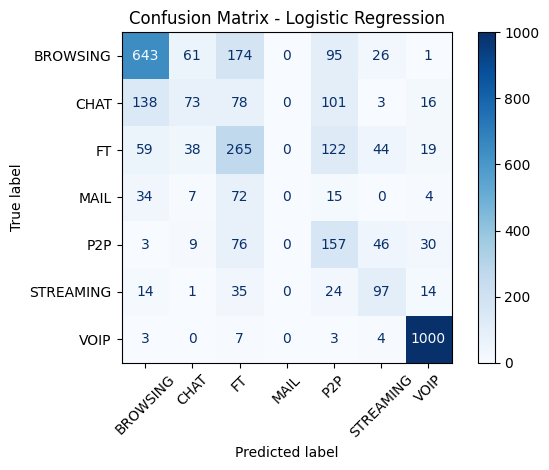

<Figure size 500x400 with 0 Axes>

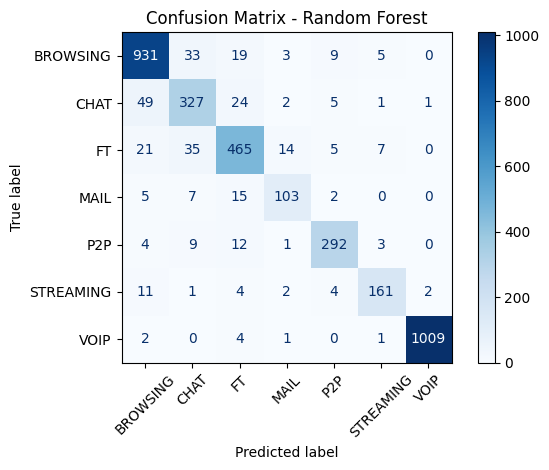

<Figure size 500x400 with 0 Axes>

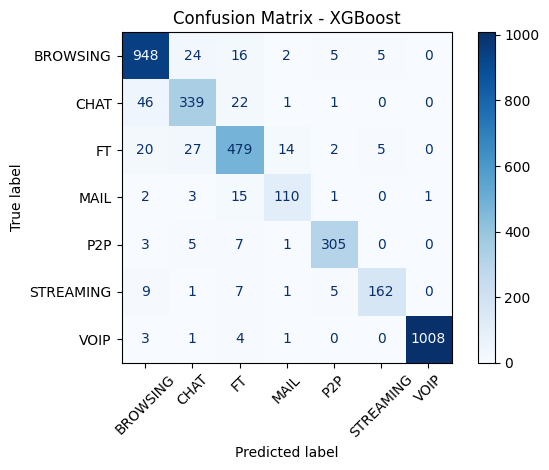

<Figure size 500x400 with 0 Axes>

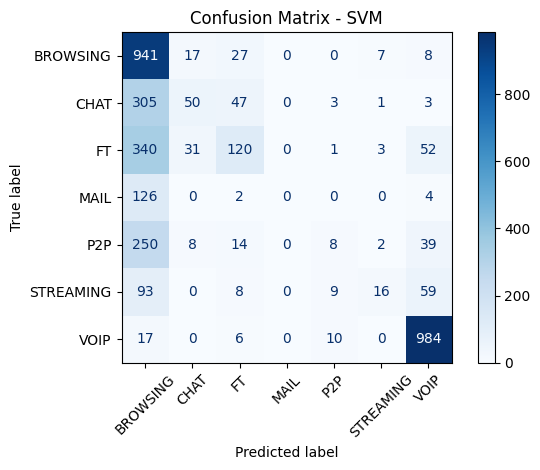

<Figure size 500x400 with 0 Axes>

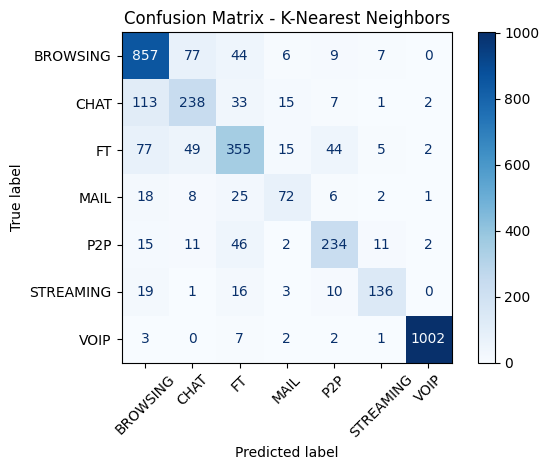

<Figure size 500x400 with 0 Axes>

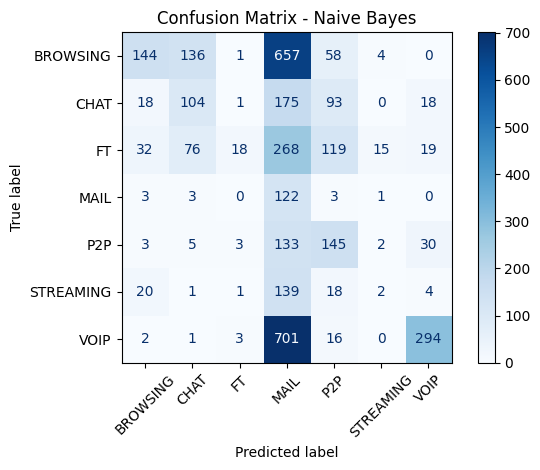

📊 Full Model Comparison Table:


,Model,Accuracy,Precision (Macro),Recall (Macro),F1 Score (Macro)
2,XGBoost,0.9280,0.9116,0.9004,0.9058
1,Random Forest,0.9106,0.8857,0.8761,0.8808
4,K-Nearest Neighbors,0.8014,0.7537,0.7261,0.7386
0,Logistic Regression,0.6189,0.4496,0.4718,0.4502
3,SVM,0.5868,0.4468,0.3374,0.3174
5,Naive Bayes,0.2296,0.4142,0.3010,0.2151


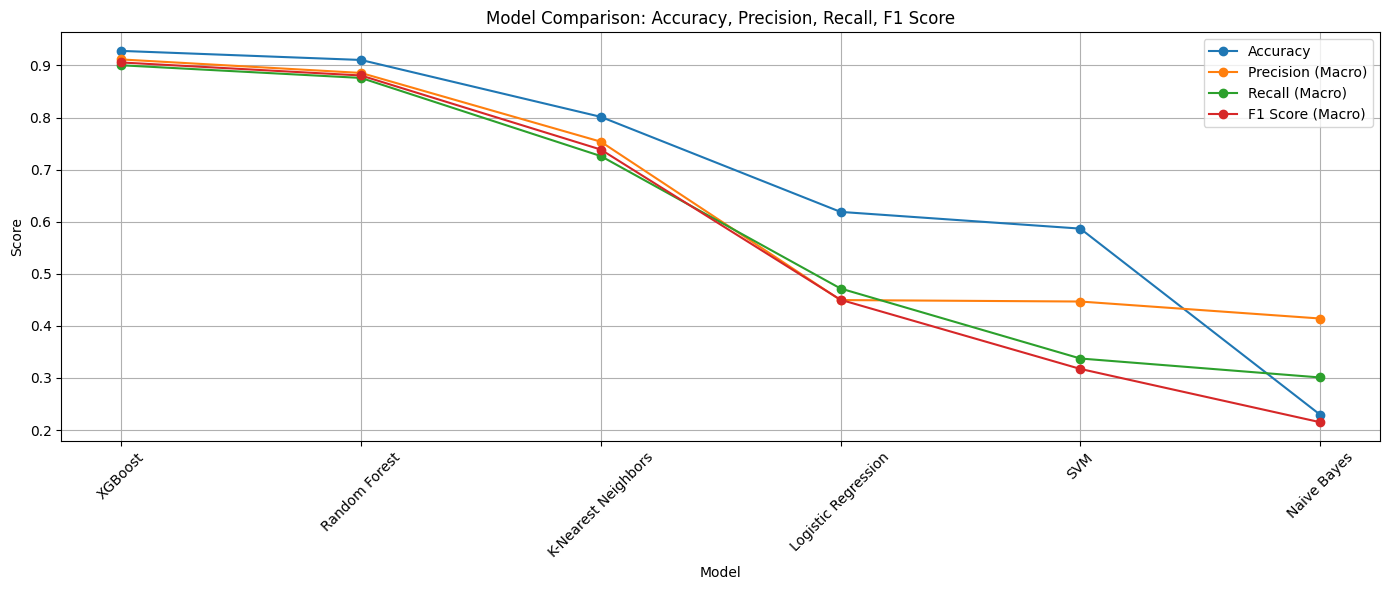

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import torch

# Initialize evaluation results list
eval_results = []

# ----- Classical ML Models Evaluation -----
for name, model in {**models, **more_models}.items():
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    eval_results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision (Macro)": round(prec, 4),
        "Recall (Macro)": round(rec, 4),
        "F1 Score (Macro)": round(f1, 4)
    })

    # Display confusion matrix
    plt.figure(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=label_encoder.classes_,
        xticks_rotation=45,
        cmap="Blues"
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

# ----- Display Full Comparison Table -----
metrics_df = pd.DataFrame(eval_results).sort_values(by="F1 Score (Macro)", ascending=False)
print("📊 Full Model Comparison Table:")
display(metrics_df)

# ----- Plot Metrics for All Models -----
plt.figure(figsize=(14, 6))
for metric in ["Accuracy", "Precision (Macro)", "Recall (Macro)", "F1 Score (Macro)"]:
    plt.plot(metrics_df["Model"], metrics_df[metric], marker='o', label=metric)

plt.title("Model Comparison: Accuracy, Precision, Recall, F1 Score")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
